# Lab 07 - Multi-Layer Perceptron

## Importing the libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

## Importing the dataset

In [27]:
dataset = pd.read_csv('Iris.csv')

le = LabelEncoder()
dataset['Species'] = le.fit_transform(dataset['Species'])
dataset = dataset.drop('Id', axis=1)


X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values.reshape(-1,1)

# One-hot encode Y
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(y)

In [28]:
dataset.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Correlation Heatmap

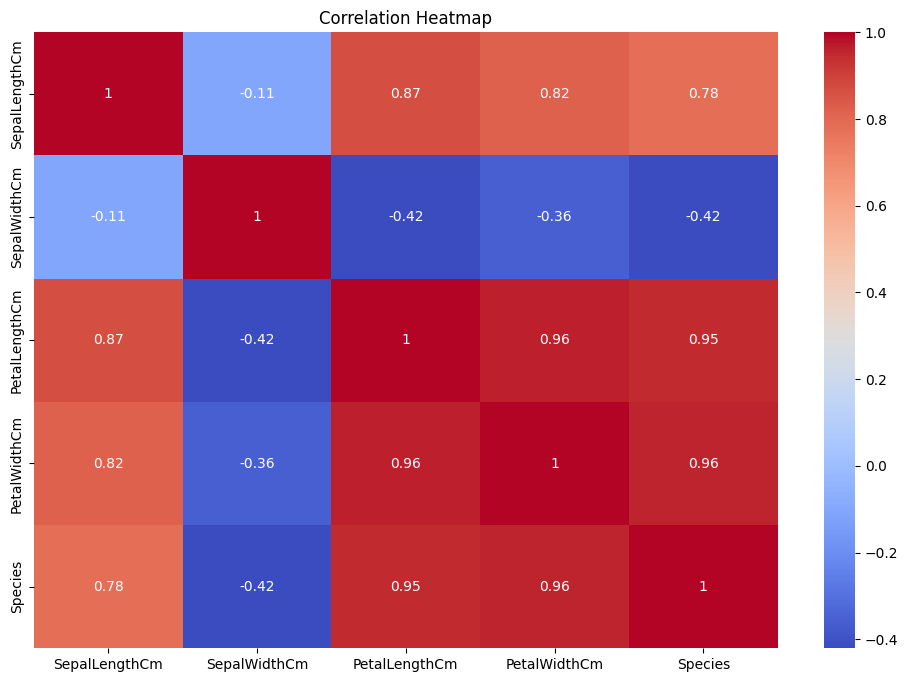

In [29]:
corr = dataset.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Normalization

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Split Train Test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Activation Functions

In [32]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0,x)

def d_relu(x):
    return (x > 0).astype(float)

def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True)  # stability
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

## Loss Function

In [33]:
# ----- Loss functions -----

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def d_mse(y_true, y_pred):
    return (y_pred - y_true) / y_true.shape[0]

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))



def binary_cross_entropy(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1 - y_pred))

def binary_cross_entropy_grad(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1-eps)
    return (-(y_true/y_pred) + (1-y_true) / (1-y_pred)) / y_true.shape[0]

## MLP Class

In [34]:
class MLP:
    def __init__(self, layer_sizes, task='classification', lr=0.001):
        """
        layer_sizes: list, e.g., [n_inputs_dime, hidden1, hidden2, ..., n_outputs_dim]
        task: 'classification' | 'multiclass' | 'regression'
        """
        
        self.lr = lr
        self.layer_sizes = layer_sizes
        self.task = task

        self.W = []
        self.B = []

        for i in range(len(layer_sizes)-1):
            self.W.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.B.append(np.zeros((1, layer_sizes[i+1])))

    # ------------Forward Pass-------------
    def forward(self, X):
        self.A = [X]
        self.Z = []

        for i in range(len(self.W)):
            z = self.A[-1] @ self.W[i] + self.B[i]
            self.Z.append(z)

            #Use ReLu for hidden layers
            if i < len(self.W) - 1:
                self.A.append(relu(z))
            else:
                if self.task == 'classification':
                    self.A.append(sigmoid(z))
                elif self.task == 'multiclass':
                    self.A.append(softmax(z))
                else:
                    self.A.append(z) # Regression
        return self.A[-1] 


    def backward(self, y_true):

        m = y_true.shape[0]
        grads_W = [None] * len(self.W)
        grads_B = [None] * len(self.B)

        # Output layer gradient
        if self.task == 'classification':
            dA = (self.A[-1] - y_true) 
        elif self.task == 'multiclass':
            dA = (self.A[-1] - y_true) # softmax + CE gradient
        else:
            dA = d_mse(y_true, self.A[-1])

        # Backpropagation
        for i in reversed(range(len(self.W))):
            if i == len(self.W) - 1: # output layer
                dZ = dA
            else:
                dZ = dA * d_relu(self.Z[i])

            grads_W[i] = self.A[i].T @ dZ
            grads_B[i] = np.sum(dZ, axis=0, keepdims=True)

            dA = dZ @ self.W[i].T
        # Gradient descent update
        for i in range(len(self.W)):
            self.W[i] -= self.lr * grads_W[i]
            self.B[i] -= self.lr * grads_B[i]
        

     # ---------- Training ----------
    def fit(self, X, y, epochs=500, verbose=True):
        losses = []
        
        for epoch in range(1, epochs+1):
            y_pred = self.forward(X)
            
            if self.task in ["classification", "multiclass"]:
                loss = cross_entropy_loss(y, y_pred)
            else:
                loss = mse_loss(y, y_pred)
                
            self.backward(y)
            losses.append(loss)
            
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch} - Loss: {loss:.4f}")
        return losses

    # ---------- Prediction ----------
    def predict(self, X):
        out = self.forward(X)
        
        if self.task == "classification":
            return (out > 0.5).astype(int)
        
        if self.task == "multiclass":
            return np.argmax(out, axis=1)
        
        return out  # regression outputs

## Binary Classification

In [35]:
# # Generate Dummy Data
# np.random.seed(0)
# X = np.random.randn(1000,2)
# y = (X[:,0] + X[:,1] > 1).astype(int).reshape(-1,1)

# mlp_bin = MLP([2,8,4,1], task='classification', lr = 0.05)
# mlp_bin.fit(X,y, epochs=1000)

# pred = mlp_bin.predict(X)
# print("Accuracy: ", np.mean(pred==y))

## Multiclassification

In [36]:
# Generate dataset
np.random.seed(0)
N = 300
X = np.random.randn(N,2)
y_raw = np.random.randint(0,3,N)

# One-hot
y = np.zeros((N,3))
y[np.arange(N), y_raw] = 1

mlp_multi = MLP([2,16,8,3], task='multiclass', lr = 0.1)
mlp_multi.fit(X,y, epochs=1000)

pred = mlp_multi.predict(X)
print("Accuracy: ", np.mean(pred==y_raw))

Epoch 100 - Loss: 6.9852
Epoch 200 - Loss: 12.7453
Epoch 300 - Loss: 11.5452
Epoch 400 - Loss: 9.1606
Epoch 500 - Loss: 10.9591
Epoch 600 - Loss: 5.2248
Epoch 700 - Loss: 12.9649
Epoch 800 - Loss: 4.3334
Epoch 900 - Loss: 7.0660
Epoch 1000 - Loss: 11.3955
Accuracy:  0.37333333333333335


## Regression / Prediction

In [37]:
# # y = 3x_1- 2x_2 + noise

# np.random.seed(0)
# X = np.random.randn(500,2)
# y = (3 * X[:,0] - 2 * X[:,1] + np.random.randn(500) * 0.2).reshape(-1,1)

# mlp_reg = MLP([2,8,4,1], task='regression', lr=0.01)
# mlp_reg.fit(X,y,epochs=500)

# pred = mlp_reg.predict(X)
# print("MSE: ", mse_loss(y,pred))

## Train and Predict Model on the test set (Binary Classification)

In [38]:
# mlp = MLP([X_train.shape[1],16,8,1], task='classification', lr=0.01)
# mlp.fit(X_train,y_train, epochs=800)

# y_pred = mlp.predict(X_test)
# acc = np.mean(y_pred == y_test)
# print("Accuracy: ", acc)


## Train and Predict Model on the Test set (Multi Classification)

In [39]:
mlp = MLP([X_train.shape[1],16, 8, 3], task='multiclass', lr=0.001)
loss = mlp.fit(X_train,y_train, epochs=10000)


y_pred = mlp.predict(X_test)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)
y_test_label = np.argmax(y_test, axis=1)
print(y_test_label)
print(y_pred)

Epoch 100 - Loss: 1.0984
Epoch 200 - Loss: 1.0984
Epoch 300 - Loss: 1.0984
Epoch 400 - Loss: 1.0983
Epoch 500 - Loss: 1.0981
Epoch 600 - Loss: 1.0960
Epoch 700 - Loss: 0.7281
Epoch 800 - Loss: 0.4314
Epoch 900 - Loss: 0.2779
Epoch 1000 - Loss: 0.1588
Epoch 1100 - Loss: 0.0998
Epoch 1200 - Loss: 0.0777
Epoch 1300 - Loss: 0.0668
Epoch 1400 - Loss: 0.0605
Epoch 1500 - Loss: 0.0564
Epoch 1600 - Loss: 0.0537
Epoch 1700 - Loss: 0.0518
Epoch 1800 - Loss: 0.0504
Epoch 1900 - Loss: 0.0494
Epoch 2000 - Loss: 0.0487
Epoch 2100 - Loss: 0.0480
Epoch 2200 - Loss: 0.0476
Epoch 2300 - Loss: 0.0472
Epoch 2400 - Loss: 0.0468
Epoch 2500 - Loss: 0.0465
Epoch 2600 - Loss: 0.0462
Epoch 2700 - Loss: 0.0460
Epoch 2800 - Loss: 0.0457
Epoch 2900 - Loss: 0.0455
Epoch 3000 - Loss: 0.0453
Epoch 3100 - Loss: 0.0451
Epoch 3200 - Loss: 0.0449
Epoch 3300 - Loss: 0.0447
Epoch 3400 - Loss: 0.0444
Epoch 3500 - Loss: 0.0442
Epoch 3600 - Loss: 0.0440
Epoch 3700 - Loss: 0.0438
Epoch 3800 - Loss: 0.0437
Epoch 3900 - Loss: 0.

## Confusion Matrix

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_label, y_pred)

## Confusion matrix visualization

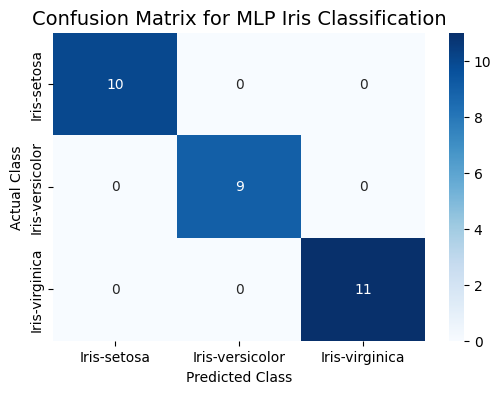

In [41]:
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("Confusion Matrix for MLP Iris Classification", fontsize=14)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


## Accuracy

In [42]:
accuracy_score(y_test_label,y_pred)

1.0

## Prediction

In [43]:
pred = mlp.predict([[4,3,1,0.2]])
print("MSE: ", mse_loss(y,pred))
print("Output class: ", pred)

MSE:  0.6666666666666666
Output class:  [1]


## Visaulization of loss History

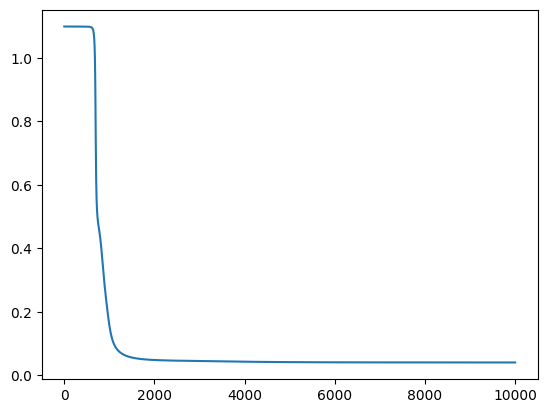

In [44]:
plt.plot(loss)